In [10]:
import astropy.units as u
from astropy.time import Time
import copy
import numpy as np
from os.path import abspath, dirname, join
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from astropy.coordinates import SkyCoord, AltAz, EarthLocation
from astroquery.vizier import Vizier
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
from ctapipe.coordinates import (
    GroundFrame,
    TiltedGroundFrame,
    NominalFrame,
    TelescopeFrame,
    CameraFrame,
    EngineeringCameraFrame,
)

In [12]:
ss_image = np.load('/Users/Jason/Software/CHECLabPySB/CHECLabPySB/d190607_pointing/DracoIm.npy')

In [13]:
# Define pointing
location=EarthLocation.from_geodetic(lon=14.974609, lat=37.693267, height=1750)
obstime=Time("2019-05-09T01:37:54.728026")

altaz_frame = AltAz(location=location, obstime=obstime)

alt = 73.21 * u.deg
az = 0.5 * u.deg

telescope_pointing = SkyCoord(
    alt=alt, 
    az=az, 
    frame=altaz_frame,
)

In [14]:
focal_length = u.Quantity(2.15191, u.m)
#focal_length = u.Quantity(2.141, u.m)

camera_frame = CameraFrame(
    location=location,
    obstime=obstime,
    focal_length=focal_length,
    telescope_pointing=telescope_pointing,
)
engineering_frame = EngineeringCameraFrame(
    n_mirrors=2,
    location=location,
    obstime=obstime,
    focal_length=focal_length,
    telescope_pointing=telescope_pointing,
)

In [15]:
# Get pixel coordinates from TargetCalib
from target_calib import CameraConfiguration
camera_config = CameraConfiguration("1.1.0")
m = camera_config.GetMapping()

xpix = np.array(m.GetXPixVector()) * u.m
ypix = np.array(m.GetYPixVector()) * u.m
size = m.GetSize() * u.m
area = size**2
pix_area = np.full(xpix.size, area) * area.unit

engineering_camera_geom = CameraGeometry(
    "CHEC",
    pix_id=np.arange(xpix.size),
    pix_x=xpix,
    pix_y=ypix,
    pix_area=pix_area,
    pix_type='rectangular',
    frame=engineering_frame
)

In [16]:
# Get stars
vizier = Vizier(
    catalog='V/50',
    columns=['_RAJ2000', '_DEJ2000', 'Vmag', 'Name']
)
t = vizier.query_region(telescope_pointing, radius=5 * u.deg, catalog='V/50')[0]
t.sort("Vmag")
t = t[:5]
stars = SkyCoord(ra=t['_RAJ2000'], dec=t['_DEJ2000'], frame='icrs')

stars_cam = stars.transform_to(camera_frame)
stars_eng = stars.transform_to(engineering_frame)

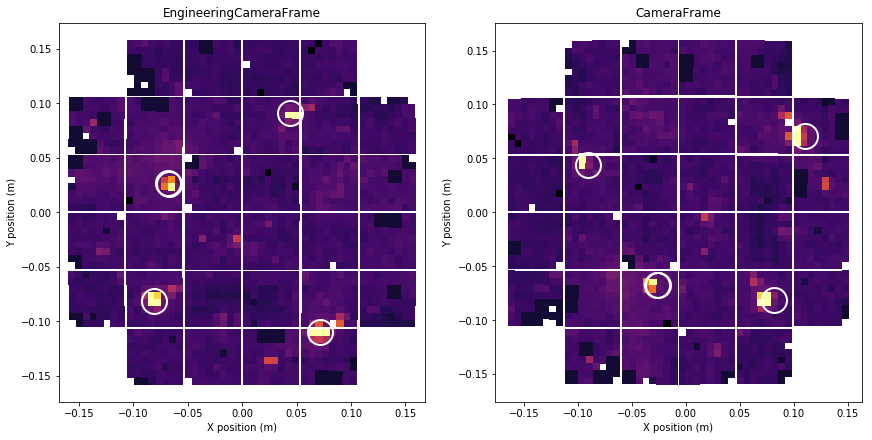

In [18]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 6))
display_camera = CameraDisplay(
    engineering2M_camera_geom, 
    ax=axs[0], 
    image=ss_image,
    title="EngineeringCameraFrame",
    cmap='inferno'
)
display_camera.set_limits_minmax(-10, 100)
display_engineering = CameraDisplay(
    engineering2M_camera_geom.transform_to(camera_frame),
    ax=axs[1],
    image=ss_image,
    title="CameraFrame",
    cmap='inferno',
)
display_engineering.set_limits_minmax(-10, 100)

axs[0].plot(stars_eng2M.x.value, stars_eng2M.y.value, 'wo', mfc='none', ms=25, mew=2)
axs[1].plot(stars_cam.x.value, stars_cam.y.value, 'wo', mfc='none', ms=25, mew=2)